In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('punkt')
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import time
from nltk import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
print("Success")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Success


In [0]:
file_path = "/content/Book1.csv"
doc=pd.read_csv(file_path,index_col=None, encoding='utf-8')

In [0]:
doc['Content.'].dropna(inplace=True)
#doc['Content.'] = doc['Content.'].astype("|S")
doc = doc[doc['Content.'].map(type)==str]

In [133]:
doc.head(25)

,article,Content.
0,doc1,How a social media firm created Korea’s fastes...
1,doc2,South Korea FinTech Gets Initial Approval For ...
2,doc3,Korea’s digital banks have two speeds: fast an...
3,doc4,Chart of the Week: Korean virtual banks still ...
4,doc5,Korean virtual banks succumb to net losses for...
5,doc6,Expert Insights Virtual banking is disrupting ...
6,doc7,South Korea is trying to make banking fun.\nNe...
7,doc8,The Future Of Banking: Virtual Banks Chase the...
8,doc9,Asia boasts one of the world’s most active fin...
9,doc10,Korea Virtual Banking\nSouth Korea Eyeing to G...


In [134]:
doc = doc.sample(frac=1.0)
doc.reset_index(drop=True,inplace=True)
doc.head()

,article,Content.
0,doc2,South Korea FinTech Gets Initial Approval For ...
1,doc9,Asia boasts one of the world’s most active fin...
2,doc10,Korea Virtual Banking\nSouth Korea Eyeing to G...
3,doc21,2019 Banking Industry Outlook\nOptimism for ba...
4,doc12,Korea\nSouth Korea’s fintech race heats up\nAN...


In [148]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

nltk.download('stopwords')
stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text
    
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
  text=[lemmatizer.lemmatize(word) for word in text if len(word)>2]
  return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return word_lemmatizer(remove_stop_words(initial_clean(text))) #stemming removed currently

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [149]:
# clean text and title and create new column "tokenized"
t1 = time.time()
doc['tokenized'] = doc['Content.'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(doc), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 24 articles: 0.008587785561879476 min


In [150]:
doc['tokenized']

0     [south, korea, fintech, get, initial, approval...
1     [asia, boast, one, world, active, financial, t...
2     [korea, virtual, bankingsouth, korea, eyeing, ...
3     [banking, industry, outlookoptimism, banking, ...
4     [koreasouth, korea, fintech, race, heat, upan,...
5     [chart, week, korean, virtual, bank, still, st...
6     [south, korea, trying, make, banking, funnew, ...
7     [social, medium, firm, created, korea, fastest...
8     [bank, brace, new, wave, digital, disruptionwh...
9     [expert, insight, virtual, banking, disrupting...
10    [financial, governance, policy, learning, kore...
11    [messaging, app, challenged, traditional, bank...
12    [singapore, central, bank, studying, licence, ...
13    [korea, virtual, bankingsouth, korea, eyeing, ...
14    [october, south, korea, main, financial, autho...
15    [korean, virtual, bank, succumb, net, loss, tw...
16    [korea, digital, bank, two, speed, fast, faste...
17    [banking, asiapacifictime, reinvent, digit

In [151]:
# first get a list of all words
all_words = [word for item in list(doc['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

4712

In [202]:
k = 10
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('bank', 674),
 ('banking', 312),
 ('financial', 290),
 ('service', 195),
 ('virtual', 169),
 ('digital', 166),
 ('customer', 166),
 ('korea', 162),
 ('new', 151),
 ('market', 135)]

In [0]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [204]:
doc['tokenized'] = doc['tokenized'].apply(keep_top_k_words)
doc['tokenized']

0     [korea, financial, service, digital, banking, ...
1     [financial, digital, financial, service, virtu...
2     [korea, virtual, korea, virtual, banking, kore...
3     [banking, banking, new, banking, financial, ba...
4     [korea, new, korea, financial, customer, bank,...
5     [virtual, bank, korea, virtual, bank, korea, b...
6     [korea, banking, banking, banking, bank, bank,...
7     [korea, bank, korea, bank, banking, digital, b...
8     [bank, new, digital, bank, customer, bank, fin...
9     [virtual, banking, financial, service, financi...
10    [financial, korea, financial, financial, finan...
11    [bank, banking, banking, korea, bank, korea, f...
12    [bank, virtual, bank, financial, bank, market,...
13    [korea, virtual, korea, virtual, banking, kore...
14    [korea, financial, bank, korea, financial, ser...
15    [virtual, bank, bank, bank, bank, korea, korea...
16    [korea, digital, bank, financial, korea, finan...
17    [banking, digital, banking, banking, finan

In [205]:
# document length
doc['doc_len'] = doc['tokenized'].apply(lambda x: len(x))
doc_lengths = list(doc['doc_len'])
doc.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 24 
average document length 100.83333333333333 
minimum document length 24 
maximum document length 315


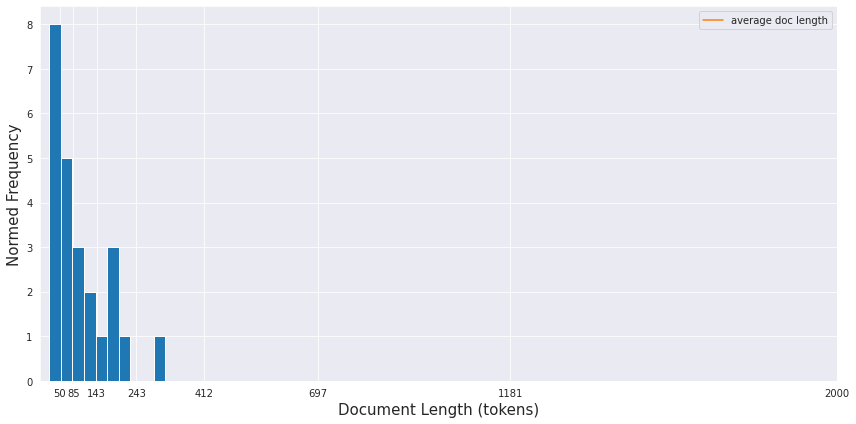

In [207]:
# plot a histogram of document length
num_bins = 10
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [208]:
# only keep articles with more than 30 tokens, otherwise too short
doc = doc[doc['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
doc = doc[doc['tokenized'].map(type) == list]
doc.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(doc), "articles")

After cleaning and excluding short aticles, the dataframe now has: 19 articles


In [0]:
# create a mask of binary values
msk = np.random.rand(len(doc)) < 0.999

In [0]:
train_doc = doc[msk]
train_doc.reset_index(drop=True,inplace=True)

test_doc = doc[~msk]
test_doc.reset_index(drop=True,inplace=True)

In [211]:
print(len(doc),len(train_doc),len(test_doc))

19 19 0


In [0]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 5
    chunksize = 30
    dictionary = corpora.Dictionary(doc['tokenized'])
    corpus = [dictionary.doc2bow(doc1) for doc1 in doc['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(doc), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [214]:
dictionary,corpus,lda = train_lda(train_doc)

Time to train LDA model on  19 articles:  0.001004791259765625 min


In [220]:
lda.show_topic(topicid=0, topn=10)

[('bank', 0.36724377),
 ('digital', 0.18106647),
 ('customer', 0.17590177),
 ('service', 0.0820359),
 ('new', 0.07875593),
 ('banking', 0.053456433),
 ('korea', 0.028211242),
 ('financial', 0.020785071),
 ('market', 0.009695195),
 ('virtual', 0.0028482757)]

In [221]:
lda.show_topic(topicid=1, topn=10)

[('virtual', 0.26595205),
 ('bank', 0.19558483),
 ('new', 0.1327998),
 ('banking', 0.10511593),
 ('service', 0.10345126),
 ('customer', 0.06540372),
 ('financial', 0.043900065),
 ('digital', 0.043175593),
 ('korea', 0.03125225),
 ('market', 0.013364566)]

In [222]:
lda.show_topic(topicid=2, topn=10)

[('financial', 0.3639336),
 ('service', 0.20577799),
 ('bank', 0.094756015),
 ('korea', 0.08504793),
 ('market', 0.07041825),
 ('banking', 0.06152726),
 ('new', 0.054420218),
 ('customer', 0.040679537),
 ('digital', 0.015131226),
 ('virtual', 0.008307983)]

In [223]:
lda.show_topic(topicid=3, topn=10)

[('bank', 0.2568022),
 ('korea', 0.24474497),
 ('financial', 0.12672916),
 ('market', 0.09187761),
 ('service', 0.09043411),
 ('digital', 0.049669903),
 ('virtual', 0.04865805),
 ('new', 0.048219964),
 ('banking', 0.030159382),
 ('customer', 0.012704701)]

In [224]:
lda.show_topic(topicid=4, topn=10)

[('bank', 0.30580047),
 ('banking', 0.18909766),
 ('virtual', 0.1043617),
 ('financial', 0.06928973),
 ('customer', 0.06803639),
 ('new', 0.06717169),
 ('digital', 0.06531612),
 ('market', 0.05959398),
 ('service', 0.038440764),
 ('korea', 0.032891534)]

In [244]:
random_article_index = np.random.randint(len(train_doc))
bow = dictionary.doc2bow(train_doc.iloc[6,2])
print(7)

7


In [250]:
print(train_doc.iloc[6,2])

['bank', 'new', 'digital', 'bank', 'customer', 'bank', 'financial', 'new', 'service', 'bank', 'bank', 'digital', 'bank', 'service', 'digital', 'service', 'bank', 'bank', 'bank', 'customer', 'banking', 'bank', 'banking', 'bank', 'banking', 'bank', 'banking', 'bank', 'bank', 'new', 'market', 'customer', 'new', 'customer', 'banking', 'bank', 'bank', 'bank', 'digital', 'banking', 'bank', 'bank', 'customer', 'digital', 'bank', 'customer', 'banking', 'service', 'digital', 'bank', 'digital', 'banking', 'digital', 'digital', 'financial', 'service', 'bank', 'customer', 'digital', 'bank', 'digital', 'new', 'new', 'digital', 'bank', 'bank', 'customer', 'digital', 'bank', 'customer', 'bank', 'customer', 'customer', 'bank', 'digital', 'customer', 'bank', 'bank', 'banking', 'digital', 'bank', 'bank', 'digital', 'bank', 'digital', 'digital', 'bank', 'digital', 'bank', 'service', 'new', 'customer', 'bank', 'new', 'service', 'bank', 'customer', 'bank', 'bank', 'bank', 'digital', 'customer', 'digital', 

In [0]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

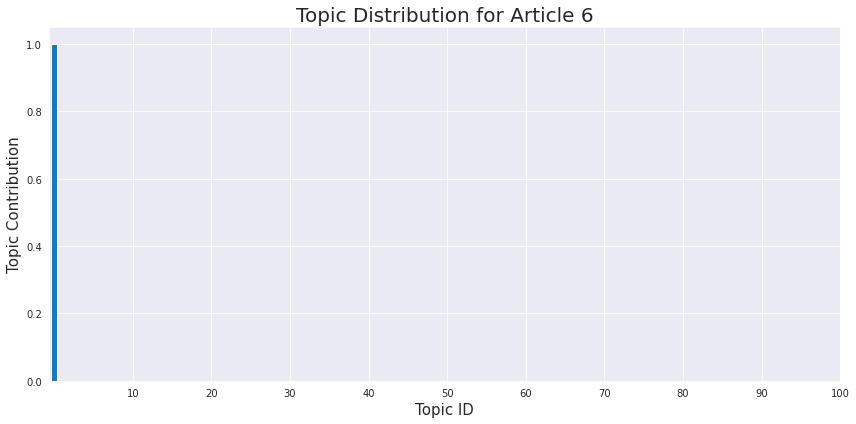

In [253]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(6), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [255]:
for i in doc_distribution.argsort()[0:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

0 [('bank', 0.36724377), ('digital', 0.18106647), ('customer', 0.17590177), ('service', 0.0820359), ('new', 0.07875593), ('banking', 0.053456433), ('korea', 0.028211242), ('financial', 0.020785071), ('market', 0.009695195), ('virtual', 0.0028482757)] 

4 [('bank', 0.30580047), ('banking', 0.18909766), ('virtual', 0.1043617), ('financial', 0.06928973), ('customer', 0.06803639), ('new', 0.06717169), ('digital', 0.06531612), ('market', 0.05959398), ('service', 0.038440764), ('korea', 0.032891534)] 

3 [('bank', 0.2568022), ('korea', 0.24474497), ('financial', 0.12672916), ('market', 0.09187761), ('service', 0.09043411), ('digital', 0.049669903), ('virtual', 0.04865805), ('new', 0.048219964), ('banking', 0.030159382), ('customer', 0.012704701)] 

2 [('financial', 0.3639336), ('service', 0.20577799), ('bank', 0.094756015), ('korea', 0.08504793), ('market', 0.07041825), ('banking', 0.06152726), ('new', 0.054420218), ('customer', 0.040679537), ('digital', 0.015131226), ('virtual', 0.008307983